<a href="https://colab.research.google.com/github/o-semenkova/ml_home_tasks/blob/main/HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay,
    roc_auc_score, f1_score
)
import joblib

In [2]:
drive.mount('/content/drive')
base_df = pd.read_csv("/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/train.csv")
base_df.head()

Mounted at /content/drive


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [3]:
# Тут можемо бачити, що всі значення присутні та імпутинг нам не потрібен

base_df.isna().sum()

,0
id,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [4]:
# Видаляємо не потрібні (бо це індекси) для аналізу колонки

base_df.drop(['id','CustomerId', 'Surname'], axis=1, inplace=True)

In [5]:
train_df, val_df = train_test_split(base_df, test_size=0.2, random_state=42, stratify=base_df['Exited'])

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору. - **Зроблено нижче у ноутбуці, бо структура трохи змінилась**

In [6]:
target_col = 'Exited'

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно. **Зроблено нижче у ноутбуці, бо структура трохи змінилась**

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [7]:
# Можемо бачити, що всі дані більш - менш рівномірні, окрім заробітноі платні, яка має дуже велику різницю між середнім та мінімальним значеннями. Це спонукає зробити аналіз на пошук викидів

train_df.select_dtypes(include=np.number).describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.0
mean,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40,0.2
std,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48,0.4
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73,0.0
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91,0.0
75%,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81,0.0
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48,1.0


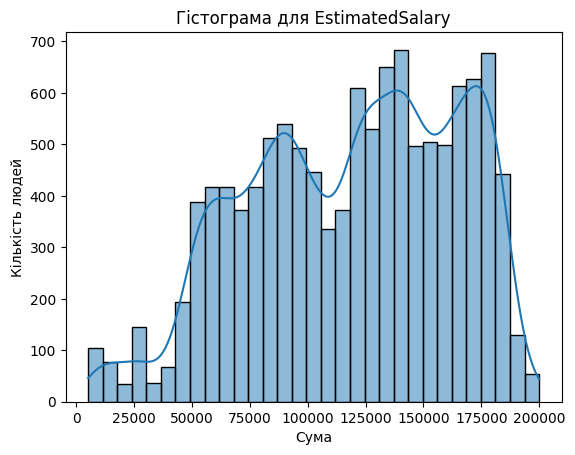

In [8]:
train_df_salary_filtered = train_df[train_df['EstimatedSalary'] > 5000]
sns.histplot(data=train_df_salary_filtered, x='EstimatedSalary', kde=True)
plt.title('Гістограма для EstimatedSalary')
plt.xlabel('Сума')
plt.ylabel('Кількість людей')
plt.show()

In [9]:
Q1 = train_df['EstimatedSalary'].quantile(0.25)
Q3 = train_df['EstimatedSalary'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [10]:
# З проведеного аналізу можемо бачити, що дійсно з мінімальними значеннями маємо не нормальну границю, можна тут заглибитись та пошукати взаємозв'язки з іншими фічами, але поки залишимо як є

lower_bound, upper_bound

(np.float64(-27009.89), np.float64(267266.43))

In [11]:
corr = train_df.corr(numeric_only=True)
corr

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.018748,0.003244,-0.006026,0.017524,0.001373,-0.000098,-0.002794,-0.051913
Age,-0.018748,1.000000,-0.008291,0.080901,-0.152121,-0.002244,-0.034247,-0.006831,0.473794
Tenure,0.003244,-0.008291,1.000000,-0.023788,0.002939,0.026538,-0.020485,0.001208,-0.008088
Balance,-0.006026,0.080901,-0.023788,1.000000,-0.436961,-0.015730,-0.009678,-0.004410,0.149822
NumOfProducts,0.017524,-0.152121,0.002939,-0.436961,1.000000,0.010404,0.029454,-0.008927,-0.285397
HasCrCard,0.001373,-0.002244,0.026538,-0.015730,0.010404,1.000000,-0.015223,-0.004990,-0.019319
IsActiveMember,-0.000098,-0.034247,-0.020485,-0.009678,0.029454,-0.015223,1.000000,-0.013291,-0.189398
EstimatedSalary,-0.002794,-0.006831,0.001208,-0.004410,-0.008927,-0.004990,-0.013291,1.000000,0.014509
Exited,-0.051913,0.473794,-0.008088,0.149822,-0.285397,-0.019319,-0.189398,0.014509,1.000000


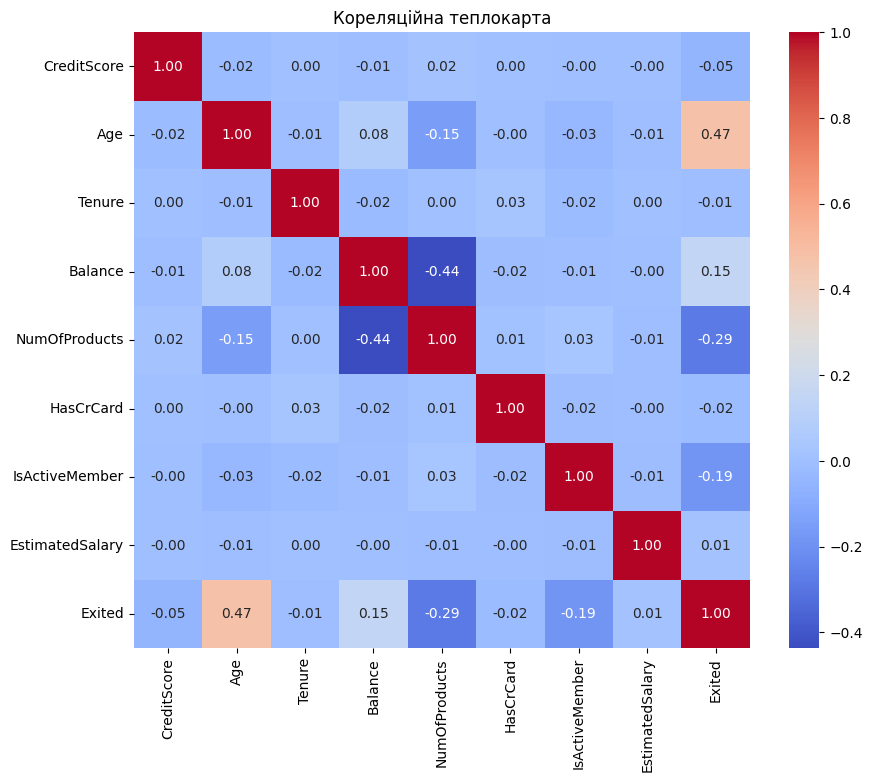

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Кореляційна теплокарта")
plt.show()

In [13]:
# Спираючись на теплову карту виділяємо значущі числові фічі для нашого таргету

significant_num_features = ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance']

In [14]:
categorical_cols = train_df.select_dtypes('object').columns.tolist()
train_df[categorical_cols].nunique()

,0
Geography,3
Gender,2


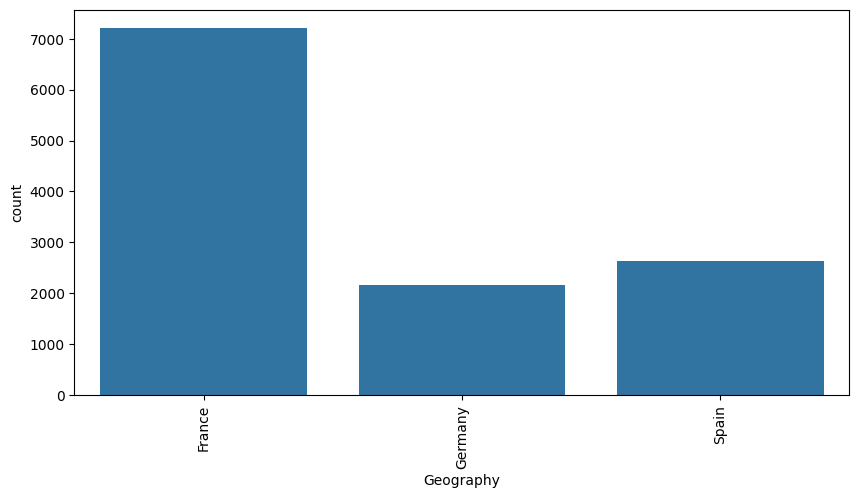

In [15]:
plt.figure(figsize = (10,5))
sns.countplot(data = train_df, x = "Geography")
plt.xticks(rotation = 90)
plt.show()

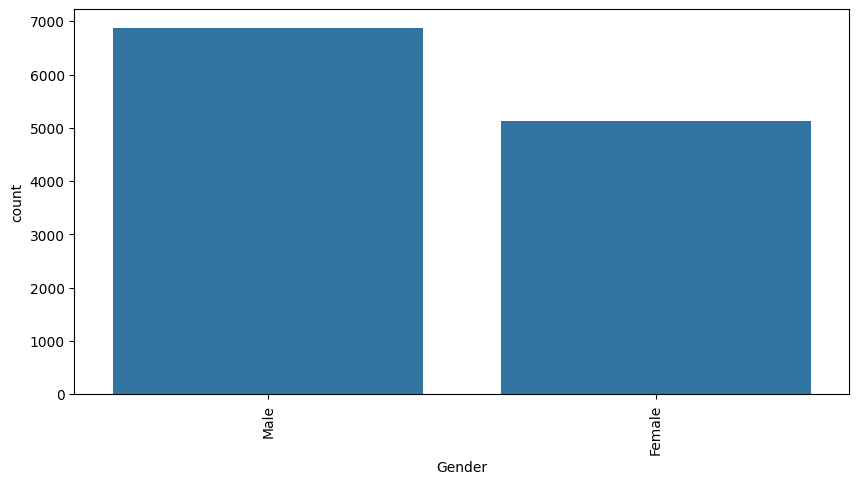

In [16]:
plt.figure(figsize = (10,5))
sns.countplot(data = train_df, x = "Gender")
plt.xticks(rotation = 90)
plt.show()

In [17]:
# 1. Відтік у розрізі HasCrCard (чи є кредитна картка)
print("HasCrCard:")
print(train_df.groupby('HasCrCard')['Exited'].mean(), "\n")

# 2. Відтік у розрізі IsActiveMember (чи активний клієнт)
print("IsActiveMember:")
print(train_df.groupby('IsActiveMember')['Exited'].mean(), "\n")

# 3. Відтік у розрізі NumOfProducts (кількість банківських продуктів)
print("NumOfProducts:")
print(train_df.groupby('NumOfProducts')['Exited'].mean())

HasCrCard:
HasCrCard
0.0    0.218601
1.0    0.199494
Name: Exited, dtype: float64 

IsActiveMember:
IsActiveMember
0.0    0.278479
1.0    0.125954
Name: Exited, dtype: float64 

NumOfProducts:
NumOfProducts
1.0    0.379786
2.0    0.043759
3.0    0.961538
4.0    0.956522
Name: Exited, dtype: float64


In [18]:
train_df['NumOfProducts'].value_counts()


,count
NumOfProducts,
2.0,6650
1.0,5145
3.0,182
4.0,23


In [19]:
def simplify_products(x):
    if x == 1:
        return '1'
    elif x == 2:
        return '2'
    else:
        return '3'

train_df['ProductGroup'] = train_df['NumOfProducts'].apply(simplify_products)
train_df.groupby('ProductGroup')['Exited'].mean()

,Exited
ProductGroup,
1,0.379786
2,0.043759
3,0.960976


In [20]:
print("Geography:")
print(train_df.groupby('Geography')['Exited'].mean())

print("Gender:")
print(train_df.groupby('Gender')['Exited'].mean())

Geography:
Geography
France     0.160172
Germany    0.411437
Spain      0.152388
Name: Exited, dtype: float64
Gender:
Gender
Female    0.283958
Male      0.143543
Name: Exited, dtype: float64


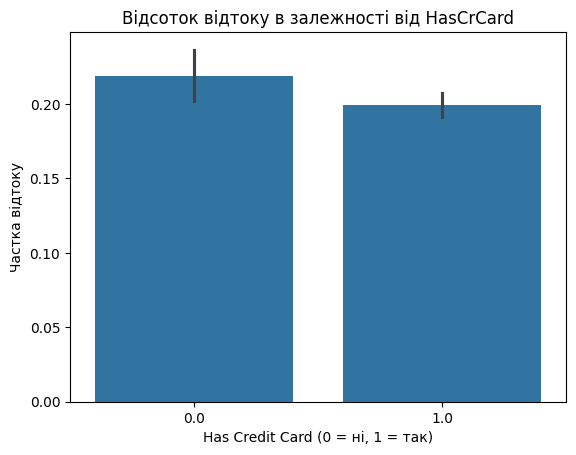

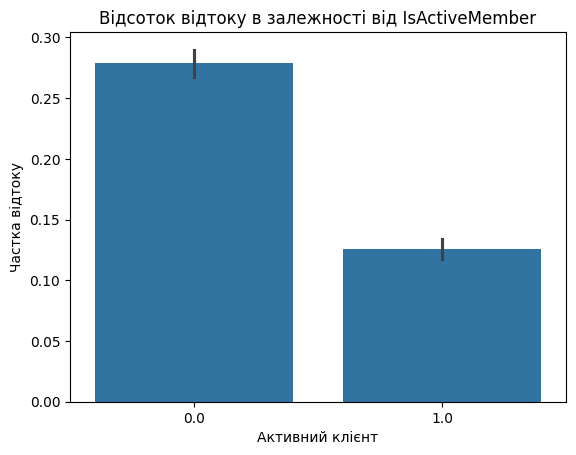

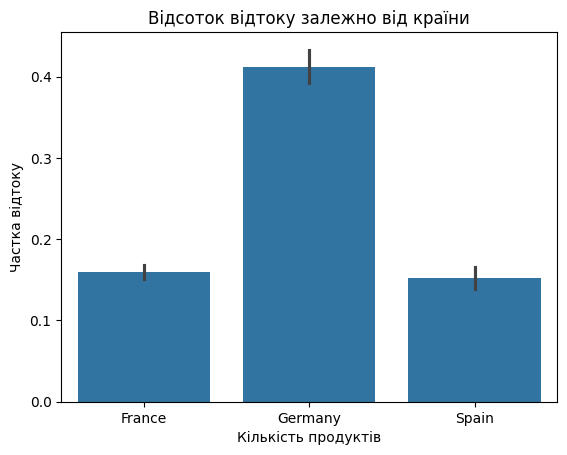

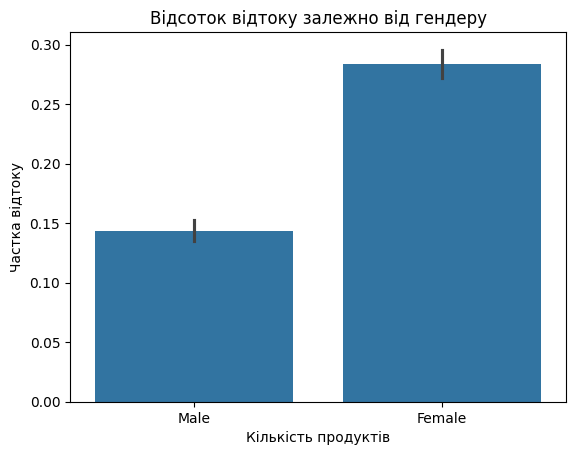

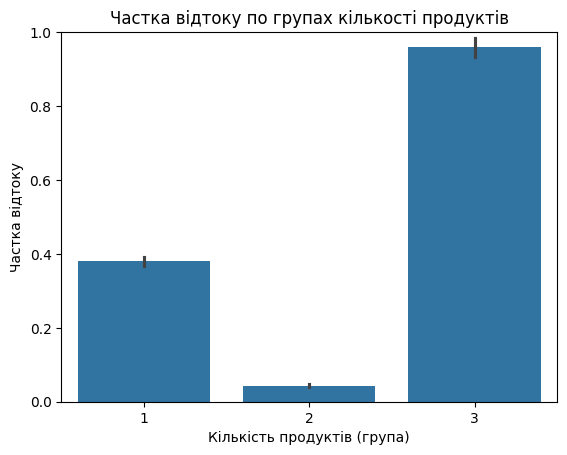

In [22]:
# HasCrCard
sns.barplot(data=train_df, x='HasCrCard', y='Exited')
plt.title('Відсоток відтоку в залежності від HasCrCard')
plt.ylabel('Частка відтоку')
plt.xlabel('Has Credit Card (0 = ні, 1 = так)')
plt.show()

# IsActiveMember
sns.barplot(data=train_df, x='IsActiveMember', y='Exited')
plt.title('Відсоток відтоку в залежності від IsActiveMember')
plt.ylabel('Частка відтоку')
plt.xlabel('Активний клієнт')
plt.show()

# Geography
sns.barplot(data=train_df, x='Geography', y='Exited')
plt.title('Відсоток відтоку залежно від країни')
plt.ylabel('Частка відтоку')
plt.xlabel('Кількість продуктів')
plt.show()

# Gender
sns.barplot(data=train_df, x='Gender', y='Exited')
plt.title('Відсоток відтоку залежно від гендеру')
plt.ylabel('Частка відтоку')
plt.xlabel('Кількість продуктів')
plt.show()

sns.barplot(x=train_df['ProductGroup'], y=train_df['Exited'], order=['1', '2', '3'])
plt.title('Частка відтоку по групах кількості продуктів')
plt.xlabel('Кількість продуктів (група)')
plt.ylabel('Частка відтоку')
plt.ylim(0, 1)
plt.show()

**Висновок**:
 - Клієнти з Німеччини — головна група ризику. Можливо, банк має гірші умови або слабший сервіс саме там.
 - Жінки значно частіше йдуть з банку, ніж чоловіки. Це важлива ознака, яку варто враховувати в моделі або таргетингу (маркетинг, підтримка).
 - 3 і 4 продукти — дуже мала вибірка:
Усього 158 клієнтів із 9000 мають 3 або 4 продукти.

Майже всі з них пішли, але висока частка — можливо, випадковість або системна причина (наприклад, спецпропозиції, які закінчились).
Їх не варто ігнорувати повністю, але в моделі може бути доцільно:
1) Об’єднати 3 і 4 в одну групу: "3" (обираємо цей варіант),
2) Або розглядати окремо, але з обережністю (низька статистична надійність).
 - Активні клієнти значно рідше йдуть. Це важлива ознака, яку варто використовувати в моделі та маркетингових інтервенціях
 - Клієнти без кредитної картки трохи частіше йдуть, але різниця дуже невелика (≈1.6%) — вплив слабкий або майже відсутній.

 **Це все дозволяє обрати для подальшої роботи значущі категоріальні фічі**

In [23]:
significant_cat_features = ['Geography', 'Gender', 'ProductGroup']
significant_features = significant_num_features + significant_cat_features

In [24]:
train_inputs = train_df[significant_features].copy()
train_targets = train_df[target_col].copy()

val_df['ProductGroup'] = val_df['NumOfProducts'].apply(simplify_products)
val_inputs = val_df[significant_features].copy()
val_targets = val_df[target_col].copy()

In [25]:
scaler = MinMaxScaler()
train_inputs = train_inputs.loc[:, ~train_inputs.columns.duplicated()]
scaler.fit(train_inputs[significant_num_features])

MinMaxScaler()

In [26]:
train_inputs[significant_num_features] = scaler.transform(train_inputs[significant_num_features])

val_inputs = val_inputs.loc[:, ~val_inputs.columns.duplicated()]
val_inputs[significant_num_features] = scaler.transform(val_inputs[significant_num_features])

In [27]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(train_inputs[significant_cat_features])
encoded_cols = list(encoder.get_feature_names_out())

In [28]:
encoded_array = encoder.transform(train_inputs[significant_cat_features])
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=train_inputs.index)

# З'єднання з оригінальним датафреймом:
train_inputs = pd.concat([train_inputs.drop(columns=significant_cat_features), encoded_df], axis=1)

In [29]:
encoded_array = encoder.transform(val_inputs[significant_cat_features])
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=val_inputs.index)

# З'єднання з оригінальним датафреймом:
val_inputs = pd.concat([val_inputs.drop(columns=significant_cat_features), encoded_df], axis=1)

In [30]:
print("Train inputs:")
display(train_inputs.head())

print("Validation inputs:")
display(val_inputs.head())

Train inputs:


,Age,NumOfProducts,IsActiveMember,Balance,Geography_Germany,Geography_Spain,Gender_Male,ProductGroup_2,ProductGroup_3
7180,0.214286,0.000000,1.0,0.626382,0.0,0.0,1.0,0.0,0.0
10393,0.375000,0.000000,0.0,0.848836,0.0,0.0,0.0,0.0,0.0
80,0.303571,0.333333,0.0,0.554522,1.0,0.0,1.0,1.0,0.0
3365,0.714286,0.333333,1.0,0.000000,0.0,1.0,1.0,1.0,0.0
12236,0.053571,0.333333,1.0,0.000000,0.0,0.0,1.0,1.0,0.0


Validation inputs:


,Age,NumOfProducts,IsActiveMember,Balance,Geography_Germany,Geography_Spain,Gender_Male,ProductGroup_2,ProductGroup_3
6490,0.500000,1.000000,1.0,0.551870,1.0,0.0,1.0,0.0,1.0
3646,0.410714,0.333333,1.0,0.000000,0.0,0.0,1.0,1.0,0.0
5306,0.357143,0.333333,1.0,0.000000,0.0,0.0,0.0,1.0,0.0
652,0.446429,0.000000,1.0,0.742441,0.0,0.0,0.0,0.0,0.0
2627,0.214286,0.333333,0.0,0.000000,0.0,1.0,0.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [31]:
# !pip install pyarrow --quiet

In [32]:
train_inputs.to_parquet('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/train_inputs.parquet')
val_inputs.to_parquet('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/val_inputs.parquet')
train_targets.to_frame().to_parquet('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/train_targets.parquet')
val_targets.to_frame().to_parquet('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/val_targets.parquet')

In [33]:
os.listdir('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification')

['train.csv',
 'test.csv',
 'sample_submission.csv',
 'train_inputs.parquet',
 'val_targets.parquet',
 'val_inputs.parquet',
 'submission_log_reg.csv',
 'bank_customer_churn_prediction.joblib',
 'train_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [34]:
model = LogisticRegression(solver='liblinear')
model.fit(train_inputs, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [35]:
def evaluate_model(model, X, y, dataset_name='Dataset'):
    # 1. Прогноз ймовірностей
    y_proba = model.predict_proba(X)[:, 1]

    # 2. Прогноз класів при порозі 0.5
    y_pred = (y_proba >= 0.5).astype(int)

    # 3. Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix: {dataset_name}')
    plt.show()

    # 4. ROC Curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title(f'ROC Curve: {dataset_name}')
    plt.show()

    # 5. Метрики
    auc = roc_auc_score(y, y_proba)
    f1 = f1_score(y, y_pred)

    print(f"📊 {dataset_name} — AUROC: {auc:.3f}, F1 Score (threshold=0.5): {f1:.3f}")


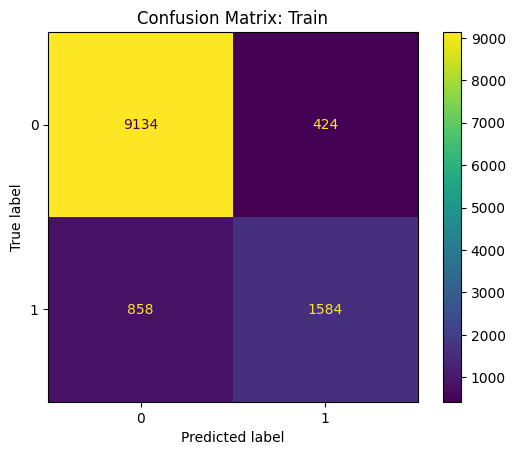

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


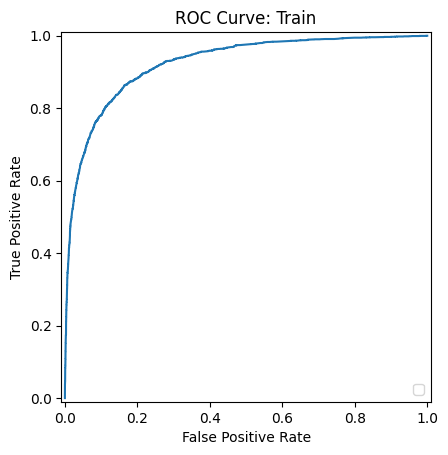

📊 Train — AUROC: 0.924, F1 Score (threshold=0.5): 0.712


In [36]:
evaluate_model(model, train_inputs, train_targets, 'Train')

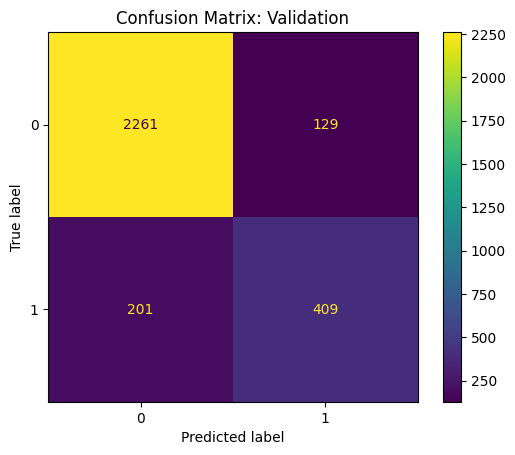

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


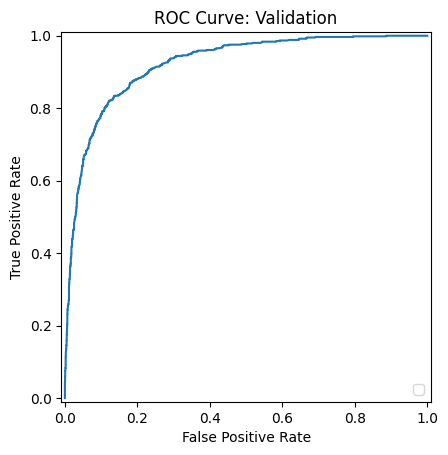

📊 Validation — AUROC: 0.922, F1 Score (threshold=0.5): 0.713


In [37]:
evaluate_model(model, val_inputs, val_targets, 'Validation')

# **Train**
 - AUROC: 0.924 — чудовий показник. Модель добре розрізняє клієнтів, які підуть, і тих, хто залишиться.

 - F1 Score: 0.712 — хороший баланс між precision і recall

# **Validation**
 - AUROC: 0.922 — майже такий самий, як на train → немає переобучення (overfitting).

 - F1 Score: 0.713 — стабільний, що говорить про добру узагальнювальну здатність.

# Що це для нас:

 Модель адекватно навченa, добре узагальнює, не переобучена.

Її вже можна:

 - використовувати на практиці (наприклад, для прогнозування відтоку),

 - використати в бізнес-рішенні — на основі predict_proba() можна будувати скоринг, таргетинг

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [38]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

def compare_with_baseline_detailed(model, train_inputs, train_targets, val_inputs, val_targets):
    # 1. Мажоритарний клас
    majority_class = train_targets.mode()[0]

    # 2. Мажоритарні передбачення
    train_baseline_preds = [majority_class] * len(train_targets)
    val_baseline_preds = [majority_class] * len(val_targets)

    # 3. Модельні передбачення
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)

    # 4. Функція підрахунку метрик
    def compute_metrics(y_true, y_pred):
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred),
            "F1 Score": f1_score(y_true, y_pred)
        }

    # 5. Обчислення метрик
    results = {
        "Train (Model)": compute_metrics(train_targets, train_preds),
        "Train (Baseline)": compute_metrics(train_targets, train_baseline_preds),
        "Validation (Model)": compute_metrics(val_targets, val_preds),
        "Validation (Baseline)": compute_metrics(val_targets, val_baseline_preds),
    }

    # 6. Вивід
    for name, metrics in results.items():
        print(f"\n📊 {name}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.3f}")



def compare_metrics_barplot(model, train_inputs, train_targets, val_inputs, val_targets):
    majority_class = train_targets.mode()[0]

    # Модельні передбачення
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)

    # Базові передбачення
    train_baseline = [majority_class] * len(train_targets)
    val_baseline = [majority_class] * len(val_targets)

    # Обчислення всіх метрик
    def collect_metrics(y_true, y_pred, label):
        return pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            'Value': [
                accuracy_score(y_true, y_pred),
                precision_score(y_true, y_pred, zero_division=0),
                recall_score(y_true, y_pred),
                f1_score(y_true, y_pred)
            ],
            'Set': label
        })

    df_metrics = pd.concat([
        collect_metrics(train_targets, train_preds, 'Train - Model'),
        collect_metrics(train_targets, train_baseline, 'Train - Baseline'),
        collect_metrics(val_targets, val_preds, 'Val - Model'),
        collect_metrics(val_targets, val_baseline, 'Val - Baseline'),
    ])

    # Побудова графіка
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_metrics, x='Metric', y='Value', hue='Set')
    plt.title('📊 Модель vs Мажоритарна модель (усі метрики)')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()


def plot_roc_curves_comparison(model, train_inputs, train_targets, val_inputs, val_targets):
    # Ймовірності позитивного класу
    train_probs = model.predict_proba(train_inputs)[:, 1]
    val_probs = model.predict_proba(val_inputs)[:, 1]

    # Мажоритарна модель — постійне значення (наприклад, 0)
    majority_class = train_targets.mode()[0]
    baseline_train_probs = np.full(len(train_targets), majority_class)
    baseline_val_probs = np.full(len(val_targets), majority_class)

    # Розрахунок ROC кривих
    fpr_train, tpr_train, _ = roc_curve(train_targets, train_probs)
    fpr_val, tpr_val, _ = roc_curve(val_targets, val_probs)
    fpr_baseline_train, tpr_baseline_train, _ = roc_curve(train_targets, baseline_train_probs)
    fpr_baseline_val, tpr_baseline_val, _ = roc_curve(val_targets, baseline_val_probs)

    # Побудова графіка
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train - Model (AUC = {roc_auc_score(train_targets, train_probs):.3f})")
    plt.plot(fpr_val, tpr_val, label=f"Val - Model (AUC = {roc_auc_score(val_targets, val_probs):.3f})")
    plt.plot(fpr_baseline_train, tpr_baseline_train, linestyle='--', label="Train - Baseline")
    plt.plot(fpr_baseline_val, tpr_baseline_val, linestyle='--', label="Val - Baseline")
    plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label="Random (AUC = 0.5)")

    plt.title('📈 ROC-криві: Модель vs Базова модель')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [39]:
compare_with_baseline_detailed(model, train_inputs, train_targets, val_inputs, val_targets)


📊 Train (Model)
Accuracy: 0.893
Precision: 0.789
Recall: 0.649
F1 Score: 0.712

📊 Train (Baseline)
Accuracy: 0.796
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

📊 Validation (Model)
Accuracy: 0.890
Precision: 0.760
Recall: 0.670
F1 Score: 0.713

📊 Validation (Baseline)
Accuracy: 0.797
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


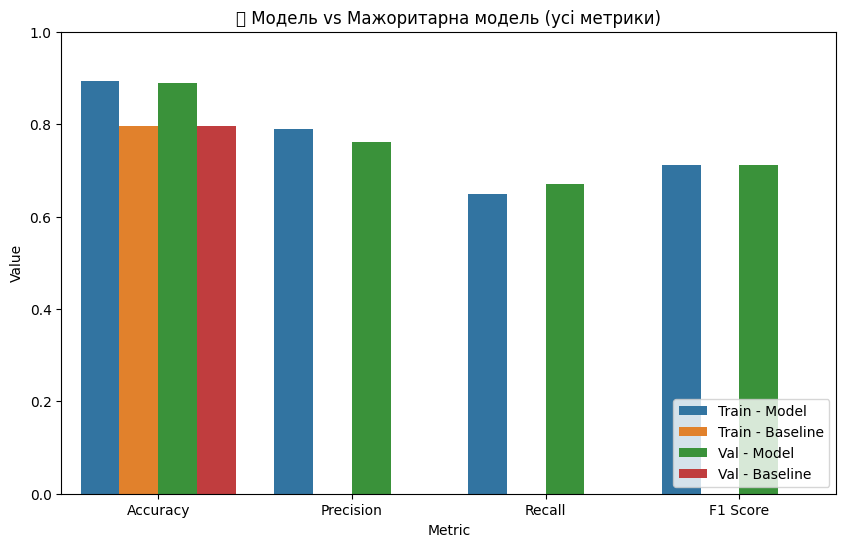

In [40]:
compare_metrics_barplot(model, train_inputs, train_targets, val_inputs, val_targets)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


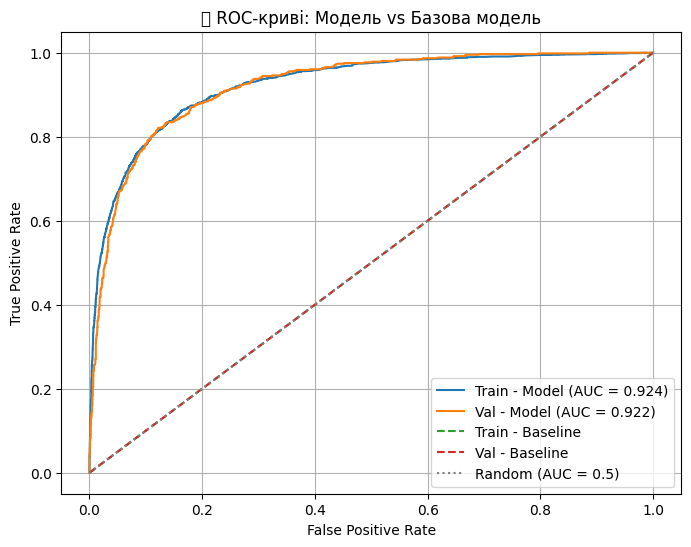

In [41]:
plot_roc_curves_comparison(model, train_inputs, train_targets, val_inputs, val_targets)


1. Модель значно краща за baseline:
Baseline просто вгадує "мажоритарний клас" (0), тому не знаходить жодного клієнта, який пішов → Precision, Recall, F1 = 0.
Модель реально навчається відрізняти тих, хто піде, і досягає високих значень.

2. Рівновага Precision/Recall:
Precision ~ 0.79 → майже 80% клієнтів, які позначені як "підуть", — справді йдуть.

Recall ~ 0.65 → модель знаходить близько 65% усіх клієнтів, які реально підуть.

F1 ~ 0.71 → дуже хороший баланс для класифікації.

3. Немає переобучення (overfitting):
Train і Validation метрики майже ідентичні → модель добре узагальнює нові дані.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [42]:
bank_customer_churn_prediction = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'significant_num_features': significant_num_features,
    'significant_cat_features': significant_cat_features,
    'target_col': target_col,
    'encoded_cols': encoded_cols
}

joblib.dump(bank_customer_churn_prediction, '/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/bank_customer_churn_prediction.joblib')

['/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/bank_customer_churn_prediction.joblib']

In [43]:
bank_customer_churn_prediction2 = joblib.load('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/bank_customer_churn_prediction.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [44]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, model, input_df: pd.DataFrame):

    # Додаємо нашу створену нову фічу
    input_df['ProductGroup'] = input_df['NumOfProducts'].apply(simplify_products)

    # Числові та категоріальні фічі: беремо з fit'нутих об'єктів
    num_cols = scaler.feature_names_in_
    cat_cols = encoder.feature_names_in_

    # Масштабування числових
    X_num = input_df[num_cols]
    X_num_scaled = scaler.transform(X_num)
    X_num_df = pd.DataFrame(X_num_scaled, columns=num_cols, index=input_df.index)

    # Енкодинг категоріальних
    X_cat = input_df[cat_cols]
    X_cat_encoded = encoder.transform(X_cat)
    X_cat_df = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out(), index=input_df.index)

    # Об'єднуємо
    X_input = pd.concat([X_num_df, X_cat_df], axis=1)

    # Прогноз
    prob = model.predict_proba(X_input)[:, 1]
    return prob


In [45]:
predict_raw_df(scaler, encoder, model, base_df[:5])

array([0.74024979, 0.0136568 , 0.99466415, 0.19209042, 0.9717125 ])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [46]:
test_raw_df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/test.csv')

In [47]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, model, test_raw_df)

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [48]:
submission_df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/sample_submission.csv')
submission_df['Exited'] = test_raw_df['Exited']
submission_df.head()


,id,Exited
0,15000,0.074822
1,15001,0.012657
2,15002,0.072848
3,15003,0.319830
4,15004,0.021410


In [49]:
submission_df.to_csv('/content/drive/MyDrive/colab_notebooks/machine-learning-by-hanna-pylieva/ml-course-notebooks/data/churn-classification/submission_log_reg.csv', index=False)